In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Data and Result Exploration

This notebook shows how to explore the data, that are loaded into ``AUCMEDI`` as well as the reults.

First, the data need to be downloaded, of course.

## Downloading the data

In [2]:
cwd = !pwd
datadir = cwd[0] + "/data"

from pathlib import Path

Path(datadir).mkdir(parents=True, exist_ok=True)

#import wget

#print('Beginning file download with wget module')

#url = 'https://zenodo.org/record/53169/files/Kather_texture_2016_image_tiles_5000.zip?download=1'
#wget.download(url, datadir)

# unzip the data

#import zipfile
#with zipfile.ZipFile("data/Kather_texture_2016_image_tiles_5000.zip","r") as zip_ref:
#    zip_ref.extractall("data")

## Plotting the images

Next we will get an overview over our data and their distribution.  

For this purpose we will first plot a few examples images of every catagory.

In [3]:
# Directories
Tumor = 'data/Kather_texture_2016_image_tiles_5000/01_TUMOR'
Stroma = 'data/Kather_texture_2016_image_tiles_5000/02_STROMA'
Complex = 'data/Kather_texture_2016_image_tiles_5000/03_COMPLEX'
Lympho = 'data/Kather_texture_2016_image_tiles_5000/04_LYMPHO'
Debris = 'data/Kather_texture_2016_image_tiles_5000/05_DEBRIS'
Mucosa = 'data/Kather_texture_2016_image_tiles_5000/06_MUCOSA'
Adipose = 'data/Kather_texture_2016_image_tiles_5000/07_ADIPOSE'
Empty = 'data/Kather_texture_2016_image_tiles_5000/08_EMPTY'

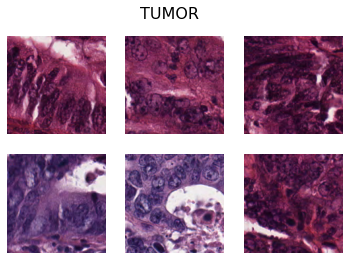

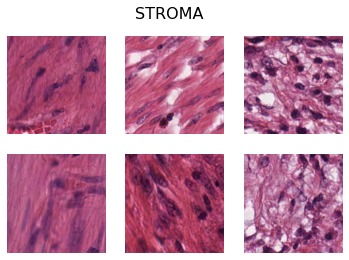

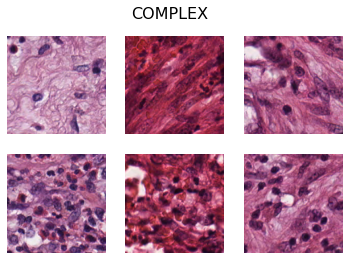

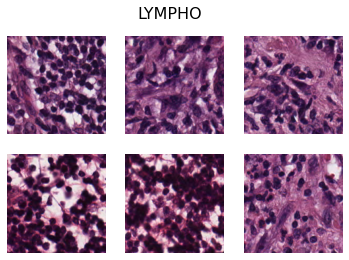

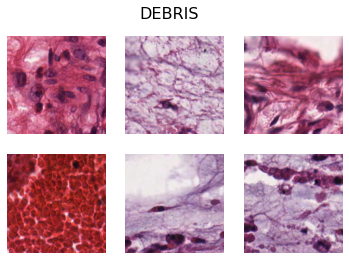

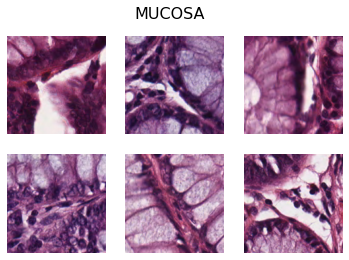

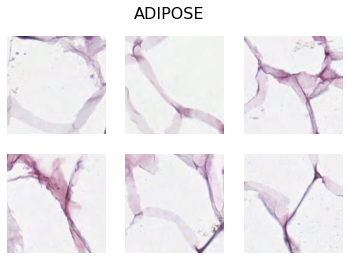

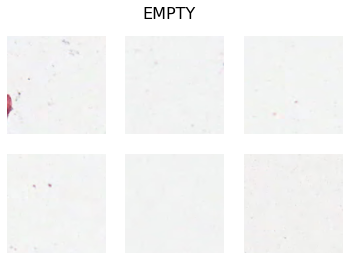

In [4]:
import matplotlib.pyplot as plt
import os

directory = [Tumor, Stroma, Complex, Lympho, Debris, Mucosa, Adipose, Empty]
for each in directory:
    category = each.split("_")[-1]
    plt.figure()
    plt.suptitle(category, fontsize=16)
    for i, file in enumerate(os.listdir(each)[0:6]):
        fullpath = each + "/" + file
        img = plt.imread(fullpath)
        plt.subplot(2, 3, i+1)
        plt.axis('off')
        plt.imshow(img)
plt.show()

Next we will have a look at the image distribution.

## Preparing the data for aucmedi

The ``input_interface`` of ``AUCMEDI`` reads the data and labels from ``directory``, from ``csv`` or from ``json``. Here we are going to read them from ``directory``.  
The ``input_interface`` gives back some useful information that we are going to use later.

In [5]:
from aucmedi.data_processing.io_data import input_interface
ds_loader = input_interface("directory", path_imagedir="data/Kather_texture_2016_image_tiles_5000", path_data=None, training=True, ohe=False)
(samples, class_ohe, nclasses, class_names, image_format) = ds_loader

2022-07-27 10:23:48.214442: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Now we are going to visualize the data-class distribution using the ``evaluate_dataset`` function of ``AUCMEDI``.  
It conventionally takes the ``samples``, one-hot-encoded classes (``class_ohe``) and the ``class_names`` that are given back from the ``input_interface`` as inputs.  
As ``out_path`` we are going to use the current working directory. 

In [6]:
from aucmedi import *
from aucmedi.evaluation.dataset import *

evaluate_dataset(samples, class_ohe, out_path="./", class_names=class_names, plot_barplot=True, plot_heatmap=True)

/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 10 x 9 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.dataset.barplot.png
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 10 x 9 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.dataset.heatmap.png


,class,class_freq,class_perc
0,01_TUMOR,625,12.0
1,02_STROMA,625,12.0
2,03_COMPLEX,625,12.0
3,04_LYMPHO,625,12.0
4,05_DEBRIS,625,12.0
5,06_MUCOSA,625,12.0
6,07_ADIPOSE,625,12.0
7,08_EMPTY,625,12.0


We can already see, that the classes are equally distributed (12% each) and that each class contains 625 images.  

Since we set the ``plot_barplot`` and ``plot_heatmap`` arguments as ``True`` we can have a view at the generated plots.  

First, let's look at the barplot:

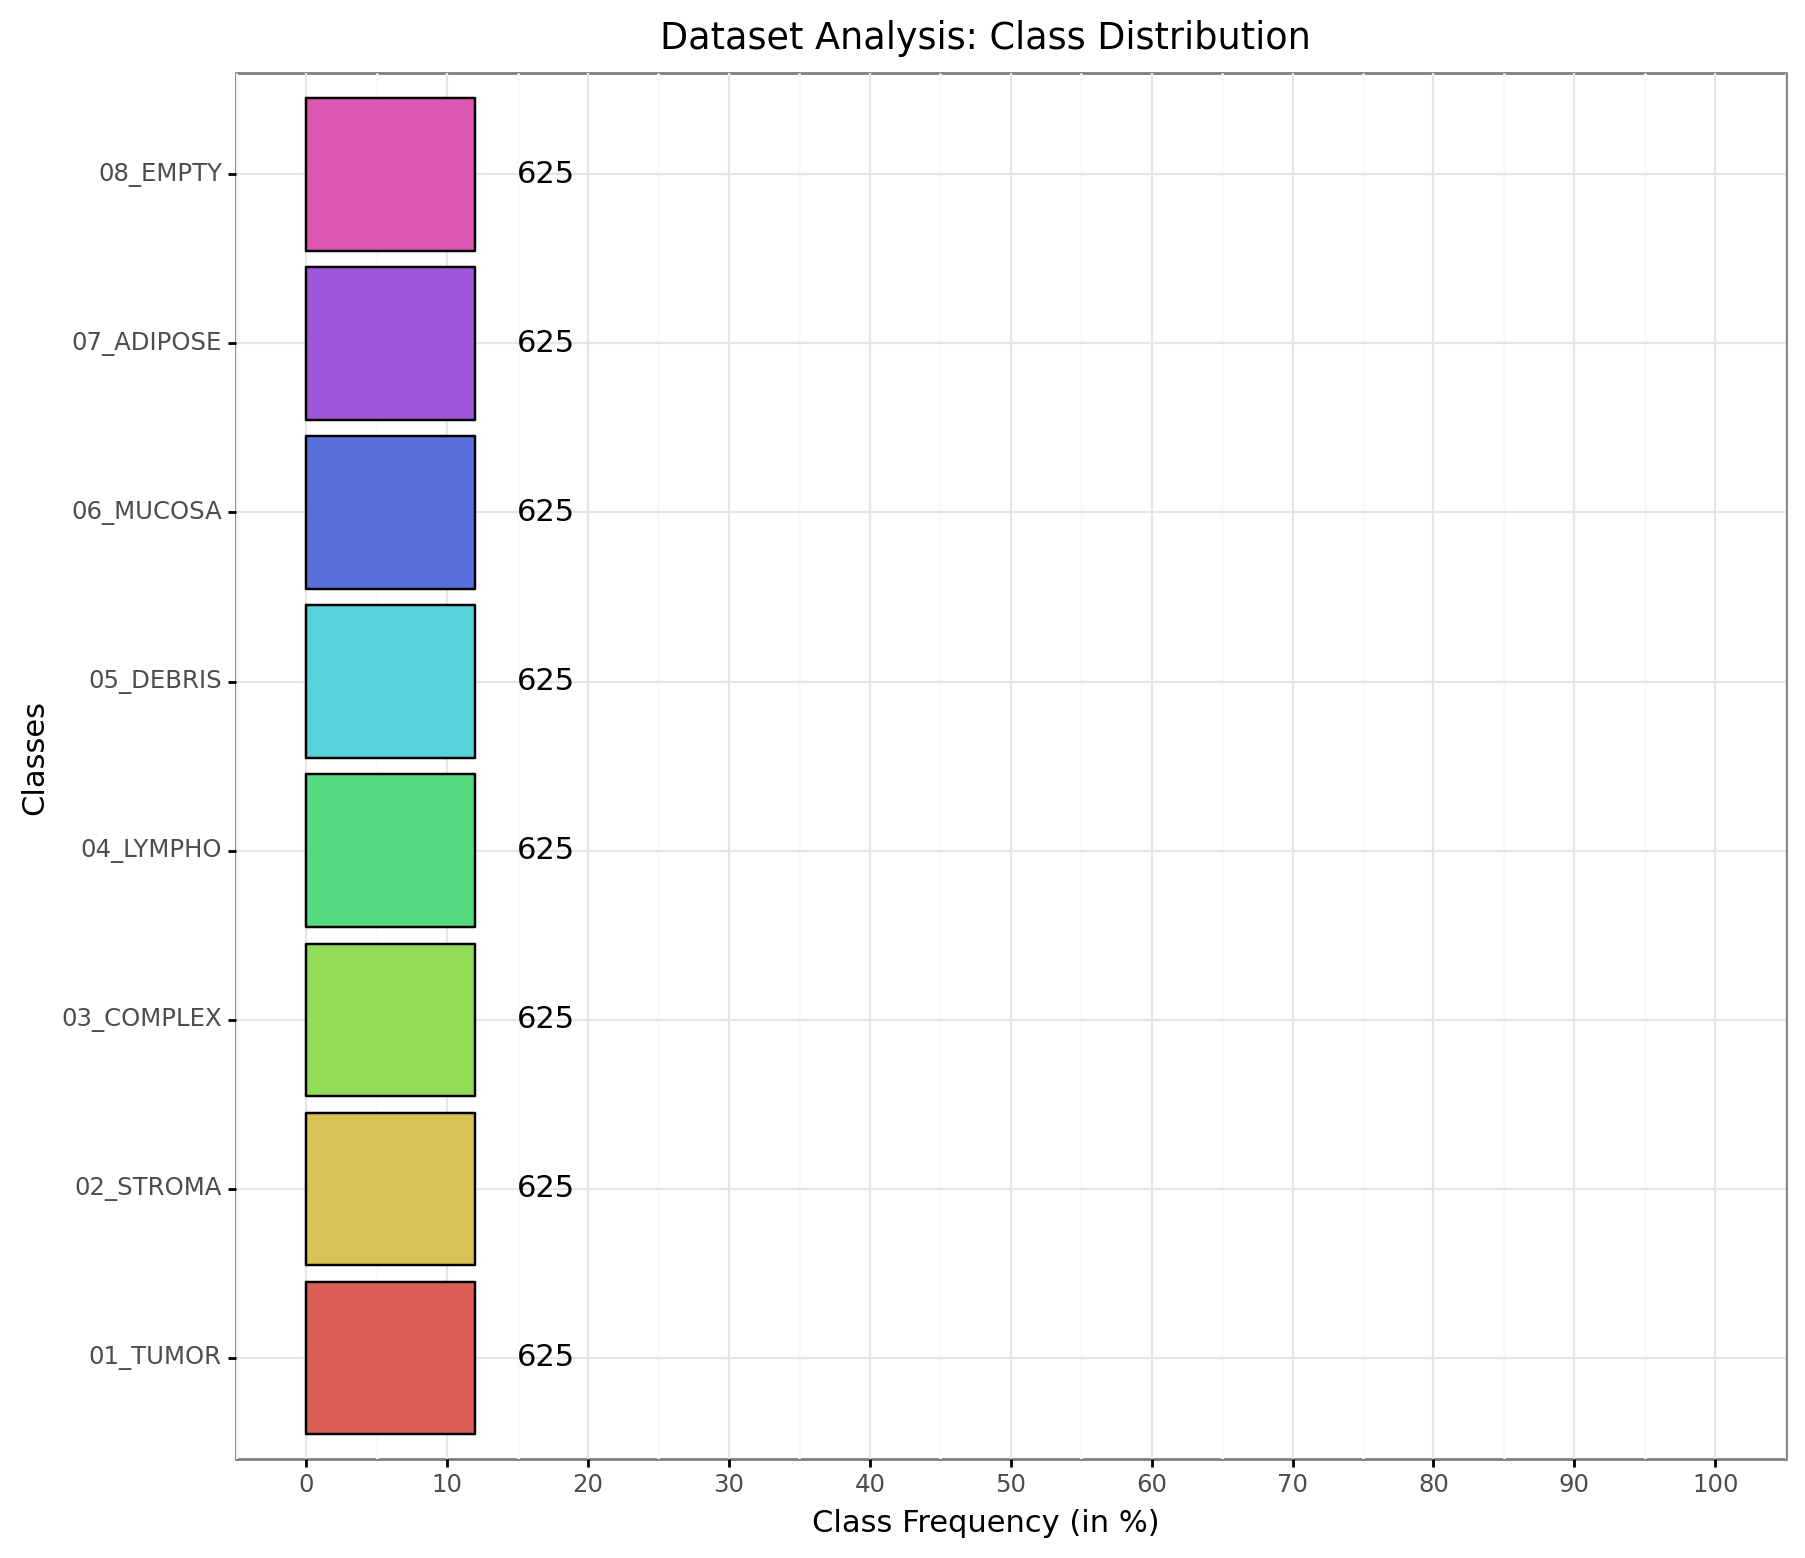

In [7]:
from PIL import Image
img = Image.open("plot.dataset.barplot.png")
img.show()

Now let's look at the heatmap:

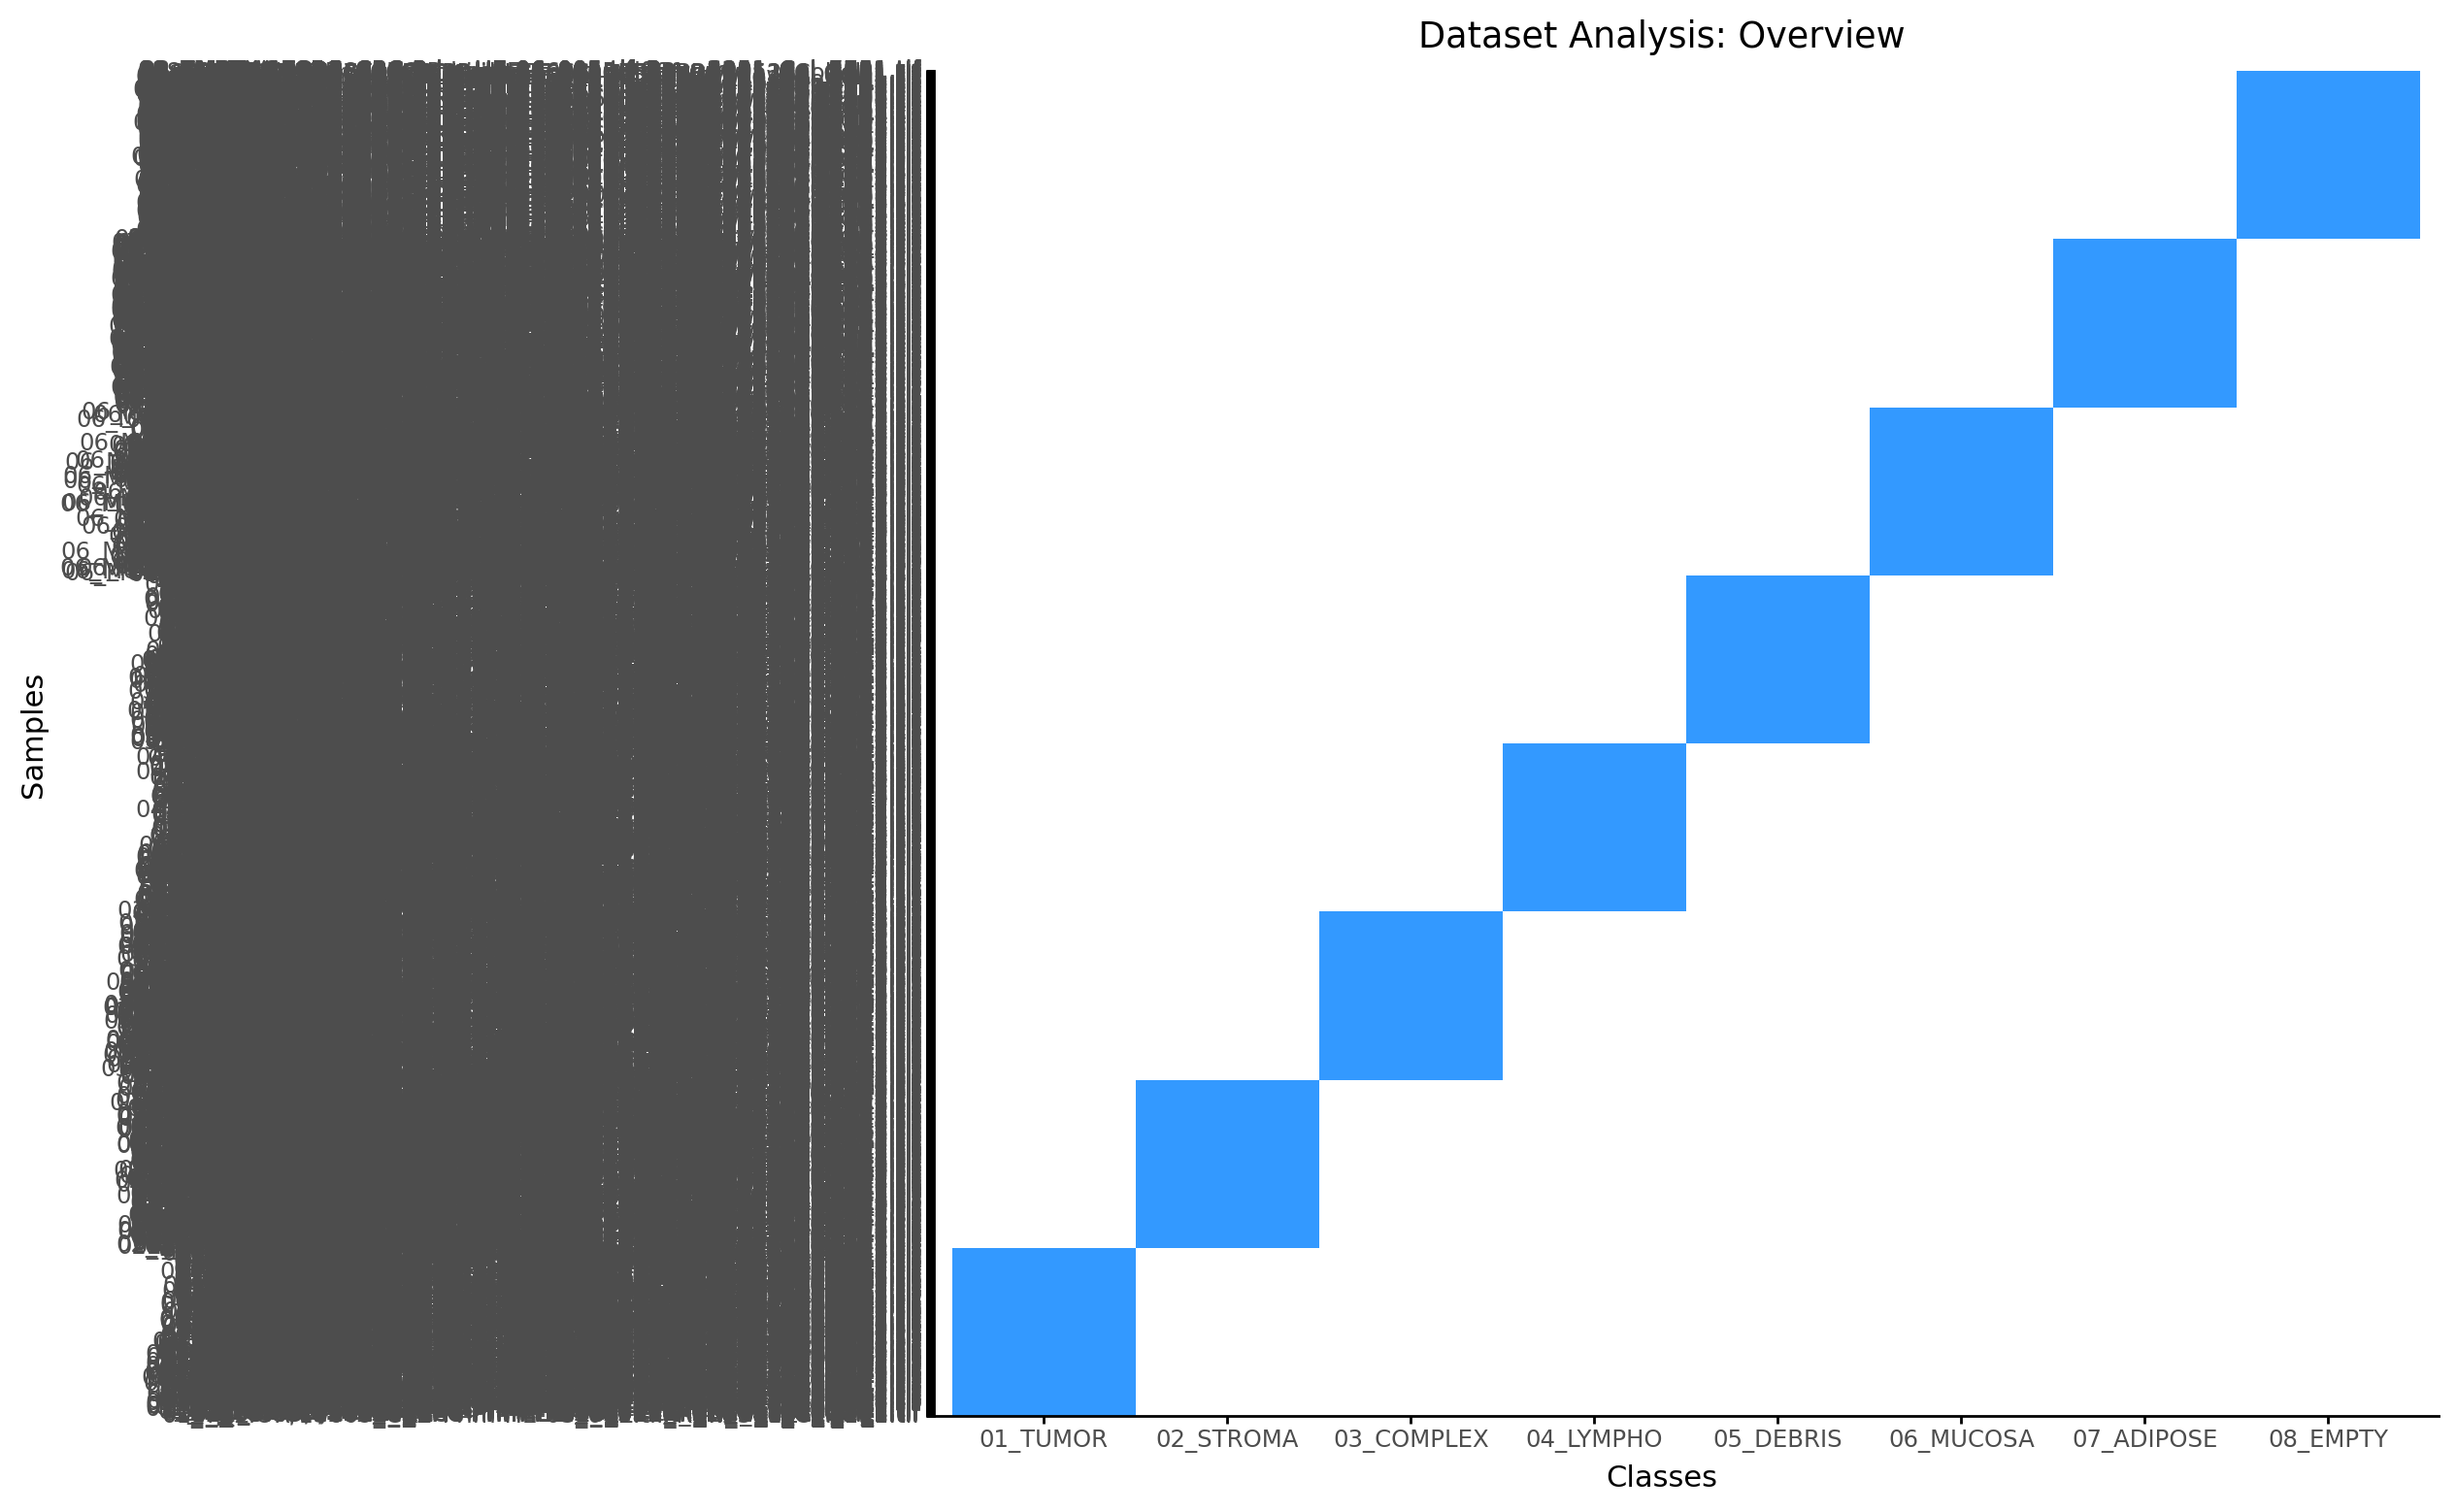

In [8]:
from PIL import Image
img = Image.open("plot.dataset.heatmap.png")
img.show()

As you can see, in our case the heatmap doesn't make to much sense: There are to many data to even read all the sample names. All we can see is, that the classes seem to be equally distributed.  

However in cases with less data, the heatmap might provide valueable information.

## Continue as usual...

Now we are continueing as usual, before we are going to have a look at the exploration of the results.  

This means, first defining a train, validation and test-Set, then defining the model and training it. If you have questions on these steps have a look in the corresponding notebooks.

So next we are going to split the dataset into a training-, validation- and test-set.

In [9]:
from aucmedi.sampling.split import sampling_split
train, validation, test = sampling_split(samples, class_ohe, sampling=[0.5, 0.25, 0.25], stratified=True, iterative=False, seed=123)

## Define the model

In [10]:
from aucmedi.neural_network.model import NeuralNetwork
import tensorflow.keras as tfa

f1Score = tfa.metrics.F1Score(num_classes=nclasses, threshold=0.5)

model = NeuralNetwork(n_labels=nclasses, channels=3, loss="categorical_crossentropy", metrics=["categorical_accuracy", f1Score], activation_output="softmax")

2022-07-27 10:25:53.304689: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-27 10:25:53.892576: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22844 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:3f:00.0, compute capability: 7.5


## Train the model

In [11]:
from aucmedi.data_processing.data_generator import DataGenerator

train_generator = DataGenerator(samples=train[0], path_imagedir="data/Kather_texture_2016_image_tiles_5000",
                                               resize=model.meta_input, standardize_mode=model.meta_standardize,
                                               labels=train[1], image_format=image_format, batch_size=32, data_aug=None, 
                                               grayscale=False, subfunctions=[], prepare_images=False, 
                                               sample_weights=None, seed=123, workers=1)
val_generator = DataGenerator(samples=validation[0], path_imagedir="data/Kather_texture_2016_image_tiles_5000",
                                             resize=model.meta_input, standardize_mode=model.meta_standardize,
                                             labels=validation[1], image_format=image_format, batch_size=32, data_aug=None, 
                                             grayscale=False, subfunctions=[], prepare_images=False, 
                                             sample_weights=None, seed=123, workers=1)

history = model.train(training_generator=train_generator, validation_generator=val_generator, epochs=20, iterations=None, 
                                         callbacks=None, class_weights=None, transfer_learning=False)

Epoch 1/20


2022-07-27 10:25:58.718274: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-07-27 10:25:59.260559: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


79/79 [==============================] - 15s 151ms/step - loss: 1.6524 - categorical_accuracy: 0.3576 - f1_score: 0.1196 - val_loss: 1.2160 - val_categorical_accuracy: 0.5560 - val_f1_score: 0.2226
Epoch 2/20
79/79 [==============================] - 12s 150ms/step - loss: 1.0964 - categorical_accuracy: 0.5728 - f1_score: 0.4021 - val_loss: 0.9142 - val_categorical_accuracy: 0.6880 - val_f1_score: 0.5248
Epoch 3/20
79/79 [==============================] - 12s 157ms/step - loss: 0.9392 - categorical_accuracy: 0.6492 - f1_score: 0.5411 - val_loss: 0.7789 - val_categorical_accuracy: 0.7264 - val_f1_score: 0.6069
Epoch 4/20
79/79 [==============================] - 11s 139ms/step - loss: 0.8148 - categorical_accuracy: 0.6848 - f1_score: 0.6232 - val_loss: 0.7180 - val_categorical_accuracy: 0.7352 - val_f1_score: 0.6383
Epoch 5/20
79/79 [==============================] - 12s 153ms/step - loss: 0.7765 - categorical_accuracy: 0.7064 - f1_score: 0.6461 - val_loss: 0.6709 - val_categorical_accura

## Evalutation of the Fitting Process

To plot the history of the training, we can use the ``AUCMEDI`` function ``evaluate_fitting``.  

With ``monitor`` we define which metric we what to diplay in the plot. The ``suffix`` added in the filename (saved in out_path) so that we can find it easier. With ``show=True`` the plot is diplayed in the notebook.

/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.fitting_course.loss.png
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


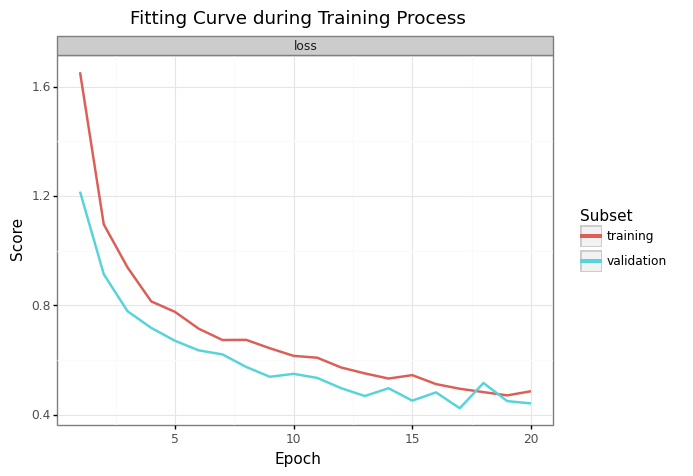

/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.fitting_course.accuracy.png


/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


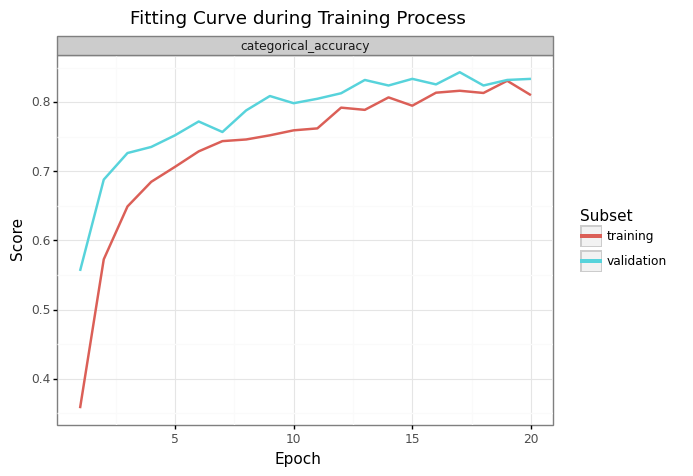

In [12]:
from aucmedi import *
from aucmedi.evaluation.fitting import *

evaluate_fitting(
    train_history = history,
    out_path = "./",
    monitor=["loss"],
    prefix_split=".",
    suffix="loss",
    show=True
)

evaluate_fitting(
    train_history = history,
    out_path = "./",
    monitor=["accuracy"],
    prefix_split=".",
    suffix="accuracy",
    show=True
)

## Predicting on the test data

Now we are going to predict on the test data.

In [14]:
from aucmedi.data_processing import data_generator

predict_generator = data_generator.DataGenerator(samples=test[0], path_imagedir="data/Kather_texture_2016_image_tiles_5000",
                                                 resize=model.meta_input, standardize_mode=model.meta_standardize,
                                                 labels=None, image_format=image_format, batch_size=32, data_aug=None, 
                                                 shuffle=False, grayscale=False, subfunctions=[], prepare_images=False, 
                                                 sample_weights=None, seed=123, workers=1)



In [15]:
prediction = model.predict(prediction_generator=predict_generator)

40/40 [==============================] - 4s 103ms/step


We can evaluate the performance of our model on the test data using the ``evaluate_performance`` function. It takes the prediction and the labels of the test-set (``test[1]``). When the ``class_names`` are provided the results are easier to interpret. With ``show=True`` the plots are displayed in the notebook.

/home/main/.local/lib/python3.8/site-packages/aucmedi/evaluation/performance.py:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 12 x 9 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.performance.barplot.png
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.

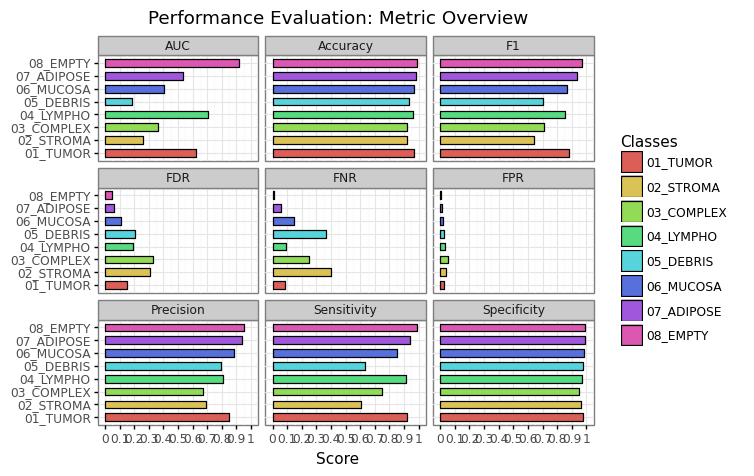

/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 10 x 9 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.performance.confusion_matrix.png


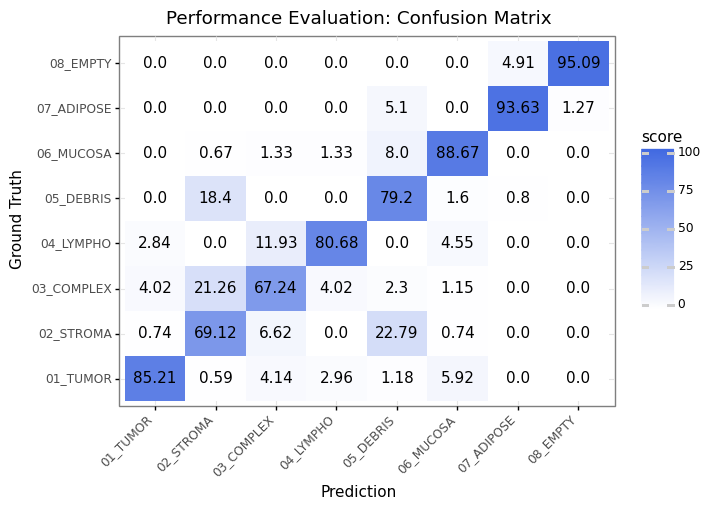

/home/main/.local/lib/python3.8/site-packages/aucmedi/evaluation/performance.py:236: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 10 x 9 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.performance.roc.png


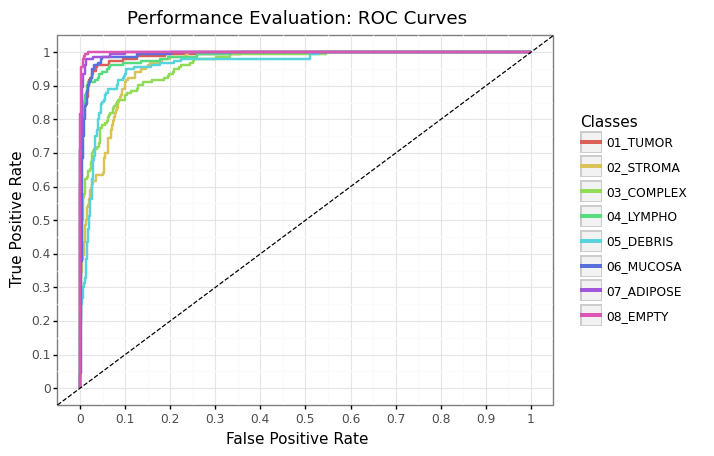

,metric,score,class
0,TP,144.000000,01_TUMOR
1,TN,1068.000000,01_TUMOR
2,FP,25.000000,01_TUMOR
3,FN,13.000000,01_TUMOR
4,Sensitivity,0.917197,01_TUMOR
...,...,...,...
99,FNR,0.012739,08_EMPTY
100,FDR,0.049080,08_EMPTY
101,Accuracy,0.992000,08_EMPTY
102,F1,0.968750,08_EMPTY


In [16]:
from aucmedi import *
from aucmedi.evaluation.performance import *

evaluate_performance(prediction, test[1], out_path="./", class_names=class_names, show=True)